In [ ]:
#hide
# from your_lib.core import *
from transplice.simulation import simulator
from transplice.random import JaxBernoulli
import jax.scipy as jsc
import jax.numpy as jnp

/home/mpm289/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Example - Fitting a 100-dimensional Gaussian

In [ ]:
import numpy
import scipy
from matplotlib import pyplot
import seaborn
import scipy.stats
from tqdm import tqdm

from gradless import optimizers, costs, gradient, updates



A major advantage of SPSA is that unlike the finite-differences approximation of the gradient (which perturbs each model parameter separately), SPSA requires only two evaluations of the cost function per gradient estimate irrespective of the model's dimension. This makes SPSA an appealling tool for optimizing high-dimensional models.

Let's say we want to fit the means and standard deviations of a 100-dimensional Gaussian to some data, so we have 200 parameters that we want to estimate.

In [ ]:
ndim=100
means=scipy.stats.norm.rvs(0, 5, size=ndim)
sd=numpy.abs(scipy.stats.norm.rvs(0,10, size=ndim))
data=scipy.stats.norm.rvs(means, sd, size=(100,ndim))
true_param=numpy.zeros(2*ndim)
true_param[::2]=means
true_param[1::2]=numpy.log2(sd)

We could frame this as Bayesian generative model

$$\mu_1 .. \mu_{100} \sim Normal(0,10)$$
$$\sigma_1 .. \sigma_{100} \sim LogNormal(0,5)$$
$$X \sim MultivariateNormal(\mu, \sigma)$$

and we could aim to identify a maximum a posteriori estimate of the model parameters.

For speed, I'm going to write the function the computes the negative log-evidence using the version of Scipy implemented in [JAX](https://github.com/google/jax), and wrap it with ```@jit``` decorate to create a compiled version of the evidence which will be much faster.

In [ ]:
import jax.numpy as jnp
import jax.scipy as jsc
from jax import jit

@jit
def evidence(theta, data):
    #priors
    mu=theta[::2]
    sd=theta[1::2]

    mu_prior=jsc.stats.norm.logpdf(mu, 0, 10).sum()
    sd_prior=jsc.stats.norm.logpdf(sd, 0, 5).sum()
    
    loglk=jsc.stats.norm.logpdf(data, mu,2.**(sd)).sum()
    return -(mu_prior+sd_prior+loglk)


Let's choose an initial guess for the optimizer and compare the negative log-evidence at the initial guess to that at the true parameter values.

In [ ]:
starts=scipy.stats.norm.rvs(0,3, size=means.shape[0]+sd.shape[0])
starts[::2]=scipy.stats.norm.rvs(0,8, size=means.shape[0])

In [ ]:
print (f"neg log evidence(theta_0) = {evidence(starts, data)}")
print (f"neg log evidence(theta_true) = {numpy.round(evidence(true_param, data))}")

neg log evidence(theta_0) = 44150716.0
neg log evidence(theta_true) = 30946.0


/home/mpm289/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


That's a pretty nasty difference in magnitude! 

In this case, we know the true value from which the data were generated, so we can get a better look at this by plotting out what the negative log-evidence looks like on a line passing from the initial guess to the true parameter value (centered at zero in the plots below). If we didn't know what the true parameter value was, we could nonetheless make some reasonable estimates of the variation in magnitudes the optimizer would potentially be dealing with. For example, by simulating datasets from the generative model and applying this procedure to the simulated data where the true parameter values were know. 

I'll plot this in linear and log-scale:

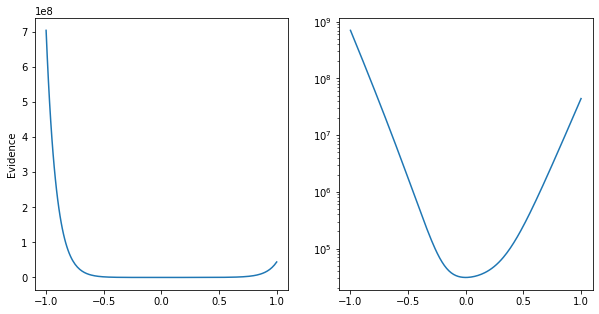

In [ ]:
param_line=true_param[:,None]+numpy.linspace(-1,1,200)*(starts-true_param)[:,None]
cost=[]
noisy_cost=[]
for i in range (200):
    cost.append(evidence(param_line[:,i], data))

pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
pyplot.plot(numpy.linspace(-1,1,200), cost)
pyplot.ylabel('Evidence')
pyplot.subplot(122)
pyplot.plot(numpy.linspace(-1,1,200), cost)
pyplot.yscale('log')


In linear scale this is quite hard to interpret, and seems likely to give an optimizer some problems, given how much the gradients will vary in scale as it explores the parameter space. The gradients are going to vary over a wide range of magnitudes, which make it hard for me to think about what sorts of step sizes are reasonable. And step sizes that work well when the gradient is extremely steep will work poorly once they become shallow (and vice versa).

However, the log-transformation is not universally appropriate for transforming negative log-likelihoods/probabilites, because they can in some circumstances be negative. Instead, if we wish to squish the scale spanned by the cost function the inverse hyperbolic sine transform (`arcsinh_transform`) is a better option. So we'll use this to transform the log-evidence so that the gradients are more consistent in scale.

In [ ]:
from gradless.math import arcsinh_transform
model=costs.Model( arcsinh_transform(evidence),
                  data)

update_rule=updates.NADAM(beta1=.99,max_step=.05)
opt=optimizers.GradientDescent(starts,model,update_rule,gradient.SPSAGradient([0,1]*ndim),
                               acceptance_rule=updates.BlockWithLocalResiduals(2,100),
                               param_stepsize = 1, param_stepdecay = .4, param_decay_offset = 0, 
                               grad_stepsize = 1, grad_stepdecay = .2, )

for i in tqdm(range(100000)):
    opt.update_params(gradient_reps=1, block_val=None)


  0%|          | 0/100000 [00:00<?, ?it/s]/home/mpm289/projects/gradless/gradless/gradient.py:99: RuntimeWarning: divide by zero encountered in true_divide
  ghat=(yplus-yminus)/(2*ck*delta)
  1%|          | 876/100000 [00:01<03:03, 539.78it/s]/home/mpm289/projects/gradless/gradless/gradient.py:99: RuntimeWarning: invalid value encountered in true_divide
  ghat=(yplus-yminus)/(2*ck*delta)
100%|██████████| 100000/100000 [03:04<00:00, 543.04it/s]


Let's visualize how the cost function improved over the iterations.

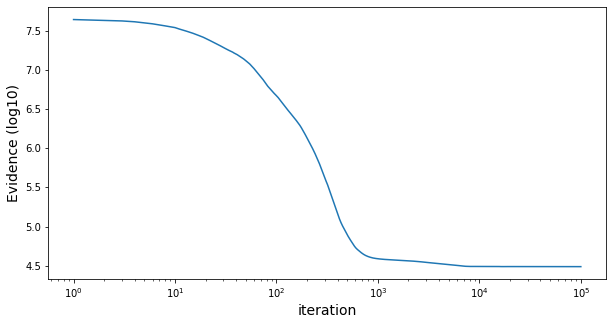

In [ ]:
#hide_inputs
pyplot.figure(figsize=(10,5))
# pyplot.subplot(121)
pyplot.plot(numpy.arange(len(opt.cost_history))+1, numpy.log10(numpy.exp(opt.cost_history)))
xscal=pyplot.xscale('log')
xlab=pyplot.xlabel('iteration', size=14)
ylab=pyplot.ylabel('Evidence (log10)', size=14)
# pyplot.subplot(122)
# pyplot.plot(numpy.log10(numpy.exp(opt.cost_history))[50000:])



Let's compare this to a MAP estimate obtained using PyMC3. I'll set up the model and fit it.

In [ ]:
import pymc3 as pm
with pm.Model() as model:
    mu=pm.Normal('mu',0,10, shape=ndim)
    std=2.**pm.Normal('sd',0,5, shape=ndim)
    obs=pm.Normal('obs',mu, std, observed=data)
with model:
#     trace=pm.sample()
    MAP=pm.find_MAP()
    
mean_mu=MAP['mu']
sd_mu=MAP['sd']

For a problem like this, ```PyMC3``` is absolutely a better choice, because objective function is not noisy. So it also serves as a nice sanity. PyMC3 uses Theano to accomplish automatic differentiation (I believe they are beginning to migrate to ```JAX```), and so it makes use of the the exact gradient. Despite only using an approximation of the gradient, SPSA arrives at essentially the same answer. The price, of course, is that it took three minutes rather than a second to run. 

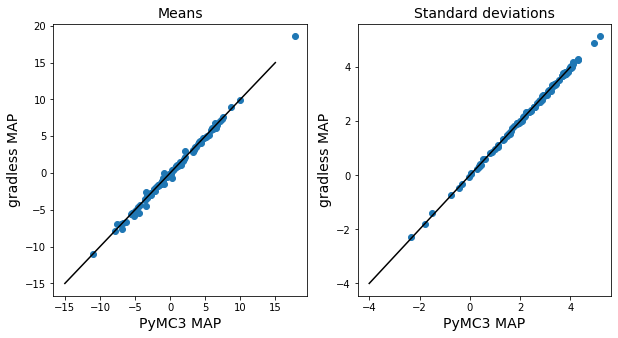

In [ ]:
#hide_inputs
theta_hist=numpy.array(opt.theta_hist)
pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
pyplot.title('Means', size=14)
pyplot.scatter(theta_hist[-1,::2], (mean_mu))
pyplot.plot([-15,15],[-15,15], color='black')
pyplot.xlabel('PyMC3 MAP', size=14)
pyplot.ylabel('gradless MAP', size=14)
pyplot.subplot(122)
pyplot.title('Standard deviations', size=14)
pyplot.scatter(theta_hist[-1,1::2], (sd_mu))
pyplot.plot([-4,4],[-4,4], color='black')
pyplot.xlabel('PyMC3 MAP', size=14)
txt=pyplot.ylabel('gradless MAP', size=14)